In [1]:
import torch
import torch.nn as nn
# import torchvision
# import torchvision.transforms as transforms
import torch.distributions as dist
from torch.utils import data
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns


# Linear regression

In [2]:
d = 50 # data dimension
N = 1500 # training set size
p = 1 # output dimension: keep to 1
T = 3500 # number of update steps
m = 1 # Minibatch size
learning_rate = 0.001
Cx = torch.ones(d, ) # gaussian isotropic case
X_dist = dist.normal.Normal(torch.zeros(d,), Cx)
X_tr = X_dist.sample((N,))
X_te = X_dist.sample((N,))
w_true = torch.randn(d,p)
Y_tr = X_tr@w_true
lanbda = 0e-2 # Regularization term
rand_mat = torch.eye(p)#torch.randn(p,p)
sigma_noise = 1/p*rand_mat.t()@rand_mat #Identity in this case
Y_tr = Y_tr + torch.randn(Y_tr.size())@sigma_noise
Y_te = X_te@w_true
Y_te = Y_te + torch.randn(Y_te.size())@sigma_noise
print(X_tr.size())

torch.Size([1500, 50])


In [3]:
H_tr = X_tr.t()@X_tr+lanbda*torch.eye(d)
H_tr_1 = torch.inverse(H_tr)
H_te = X_te.t()@X_te+lanbda*torch.eye(d)
H_te_1 = torch.inverse(H_te)

In [4]:
def estimate_C(model, loader):
#     w = list(model.parameters)[0].t()
    C = torch.zeros(d,d)
    for data, target in loader:
        grad = data.t()@(model(data)-target)
        C += grad@grad.t()/len(loader)
    return C.detach()
    
    
    

In [5]:
def get_batch(X, m):
    indices = np.random.randint(0, X.size(0), m)
    X_i = X[indices, :]
    return X_i

In [6]:
class LinearReg(nn.Module):
    def __init__(self, d, p):
        super(LinearReg, self).__init__()
        self.fc1 = nn.Linear(d, p, bias=False) 
        
    def forward(self, x):
        out = self.fc1(x)
        return out
model = LinearReg(d, p)

In [7]:
def grad_norm2(model):
    tot = 0
    for p in model.parameters():
        tot += (p.grad**2).sum().item()
    return tot


In [8]:
train_data = data.TensorDataset(X_tr, Y_tr)
test_data = data.TensorDataset(X_te, Y_te)
train_loader = data.DataLoader(dataset=train_data, 
                                           batch_size=m, 
                                           shuffle=True)
test_loader = data.DataLoader(dataset=test_data, 
                                           batch_size=m, 
                                           shuffle=True)


criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0., weight_decay=learning_rate*lanbda)  

In [9]:
def train(model, T):
    model.train()
    t = 0
    loss_tr = []
    loss_te = []
    grad_magnitude = []
    cov_tr = []
    cov_te = []
    for i in range(100000):
        for data, target in train_loader:
            t += 1
            pred = model(data)
            loss = criterion(pred, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_tr.append(test(train_loader, model))
            loss_te.append(test(test_loader, model))
            grad_magnitude.append(grad_norm2(model))
            C_tr = estimate_C(model, train_loader)
            C_te = estimate_C(model, test_loader)
            cov_tr.append(C_tr)
            cov_te.append(C_te)
            if t == T:
                return loss_tr, loss_te, grad_magnitude, cov_tr, cov_te
    
    


In [10]:
def test(X, model):
    model.eval()
    total_loss = 0
    for data, target in X:
        pred = model(data)
        loss = criterion(pred, target)
        total_loss += loss.item()/len(X)
    return total_loss

In [11]:
loss_tr, loss_te, grad, cov_tr, cov_te = train(model, T)
    

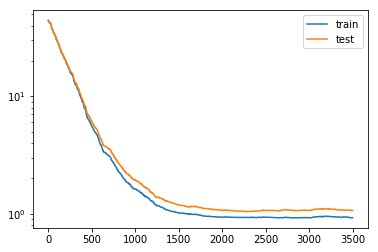

In [12]:
plt.semilogy(loss_tr, label='train')
plt.semilogy(loss_te, label='test')
plt.legend()

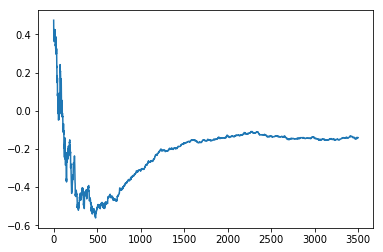

In [13]:
gap = [(te - tr) for te, tr in zip(loss_tr, loss_te)]
plt.plot(gap)

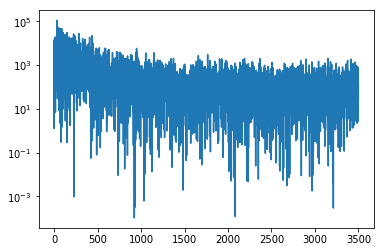

In [14]:
plt.semilogy(grad)

In [15]:
trHC_tr = [torch.trace(H_tr@C) for C in cov_tr]
trHC_te = [torch.trace(H_te@C) for C in cov_te]
trH1C_tr = [torch.trace(H_tr_1@C) for C in cov_tr]
trH1C_te = [torch.trace(H_te_1@C) for C in cov_te]

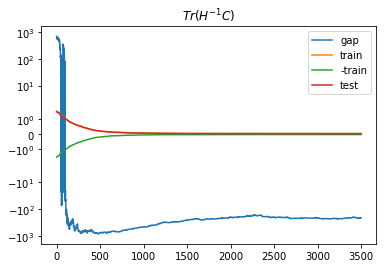

In [16]:
plt.title(r'$Tr(H^{-1}C)$')
plt.plot([el*N for el in gap], label='gap')
plt.plot(trH1C_tr, label='train')
plt.plot([-el for el in trH1C_tr], label='-train')
plt.plot(trH1C_te, label='test')

plt.legend()
# plt.ylim([0, .2])
plt.yscale('symlog')

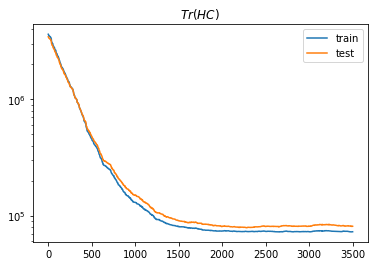

In [17]:
plt.title(r'$Tr(HC)$')
plt.plot(trHC_tr, label='train')
plt.plot(trHC_te, label='test')
plt.legend()
plt.yscale('log')

In [18]:
def frob_sim(A,B):
    normA = torch.sqrt(torch.trace(A.t()@A))
    normB = torch.sqrt(torch.trace(B.t()@B))
    prodAB = torch.trace(A.t()@B)
    return prodAB/(normA*normB)

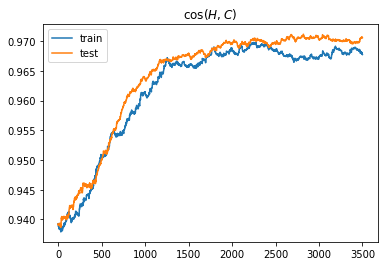

In [19]:
plt.title(r'$\cos(H, C)$')
plt.plot([frob_sim(H_tr, C) for C in cov_tr], label='train')
plt.plot([frob_sim(H_te, C) for C in cov_te], label='test')
plt.legend()
# plt.yscale('log')

In [20]:
scaled_trHC_tr = [learning_rate*.5*el for el in trHC_tr]
scaled_trHC_te = [learning_rate*.5*el for el in trHC_te]
ratio = [p/(p+q) for p, q in zip(scaled_trHC_tr, grad)]

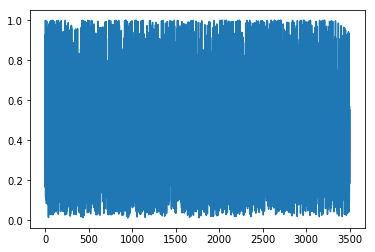

In [21]:
plt.plot(ratio)

In [22]:
sumpq = [(p-q) for p, q in zip(scaled_trHC_tr, grad)]

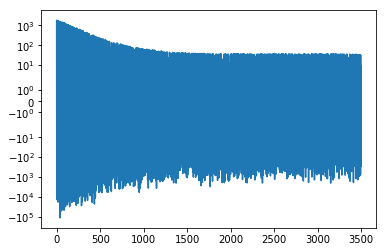

In [23]:
plt.plot(sumpq)
# plt.plot([p for p in scaled_trHC_tr], '--')
# plt.plot(grad, '--')
plt.yscale('symlog')

In [24]:
list(model.parameters())[0]-w_true

tensor([[ 0.0071, -0.9143, -1.7534,  ..., -0.6901,  1.1489, -0.8533],
        [ 0.8895, -0.0318, -0.8710,  ...,  0.1923,  2.0313,  0.0291],
        [ 1.7286,  0.8072, -0.0319,  ...,  1.0313,  2.8704,  0.8682],
        ...,
        [ 0.7175, -0.2039, -1.0430,  ...,  0.0203,  1.8593, -0.1429],
        [-1.0997, -2.0211, -2.8602,  ..., -1.7970,  0.0421, -1.9601],
        [ 0.8101, -0.1113, -0.9504,  ...,  0.1129,  1.9519, -0.0503]])

In [25]:
data

<module 'torch.utils.data' from '/Users/valentin/anaconda/envs/torch4/lib/python3.6/site-packages/torch/utils/data/__init__.py'>

In [26]:
for data, target in test_loader:
    pred = model(data)
    loss = criterion(pred, target)

In [27]:
loss

tensor(0.7996)

In [28]:
len(train_loader)

1500

In [29]:
test(test_loader, model)

1.064108933289628

In [30]:
tot = 0
for data, target in test_loader:
    pred = model(data)
    loss = criterion(pred, target)
    tot+=loss.item()